In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from anticor_features.anticor_features import get_anti_cor_genes
import topo as tp
from topo.tpgraph.intrinsic_dim import IntrinsicDim

In [2]:
import datetime
print(datetime.datetime.now())

2025-02-21 11:57:05.432502


In [3]:
counts = pd.read_csv('./data/xenoturbella/starterpack/GSM6469642_Xenoturbella_sc_expression.tsv', sep='\t')
celltypes = pd.read_csv('./data/xenoturbella/starterpack/GSM6469642_Xenoturbella_sc_cell_tpye_assignments.txt', sep='\t', header=None, index_col=0)
metacells = pd.read_csv('./data/xenoturbella/starterpack/GSM6469642_Xenoturbella_sc_mc_assignments.tsv.gz', sep='\t', header=None, index_col=0)

genes = pd.read_csv('./data/xenoturbella/starterpack/xboc_gene_annotation' , sep='\t', index_col=0)

In [4]:
adata = sc.AnnData(counts.T)
adata.obs['celltype'] = celltypes
adata.obs['metacells'] = metacells

In [5]:
adata.var = adata.var.join(genes.astype(str))

In [6]:
adata

AnnData object with n_obs × n_vars = 12350 × 16721
    obs: 'celltype', 'metacells'
    var: 'Pfam_domain_architecture', 'Homo_BBH', 'Drosophila_BBH'

In [7]:
adata.write_h5ad('./data/xenoturbella/starterpack/xenoturbella.h5ad')

In [8]:
adata.var['gene_string'] = ' (' + adata.var['Homo_BBH'].fillna('-').str[:50] + ')'
adata.var['gene_string'] = adata.var['gene_string'].str.replace(' (-)', '')
adata.var['best_guess'] = adata.var.index + adata.var['gene_string']
adata.var.drop(columns=('gene_string'), inplace=True)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_qc.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  else adata.var[gene_symbols][top_idx]


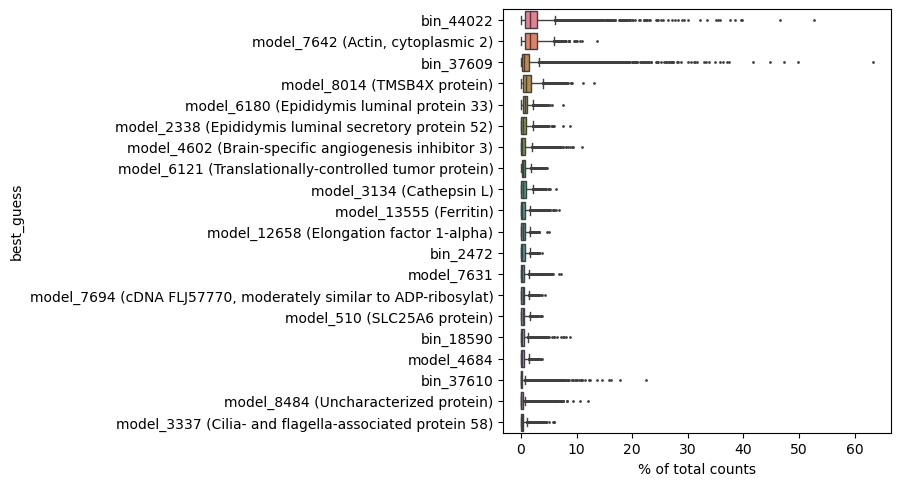

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='best_guess')

In [10]:
adata.var["mt"] = adata.var['best_guess'].str.contains('mitoch')
adata.var["ribo"] = adata.var['best_guess'].str.contains('ribosom')
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


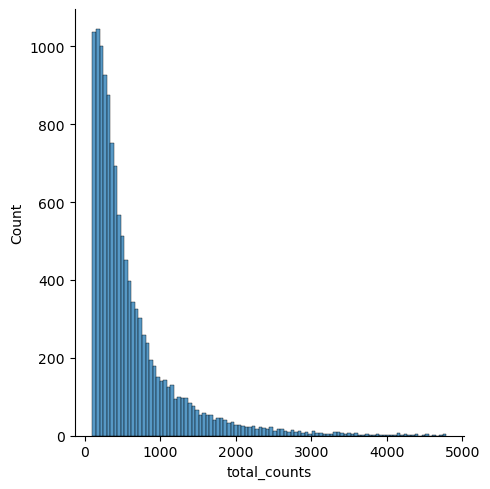

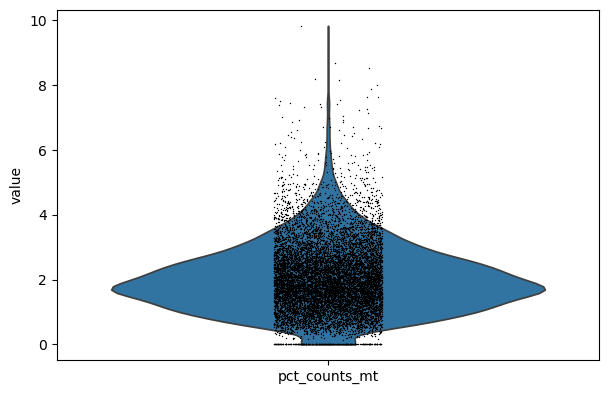

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


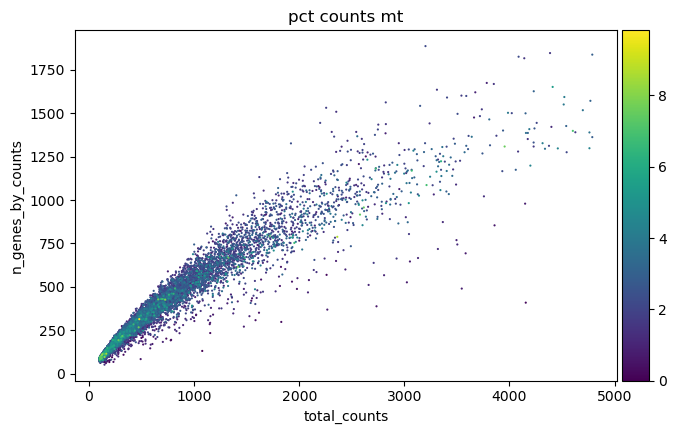

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


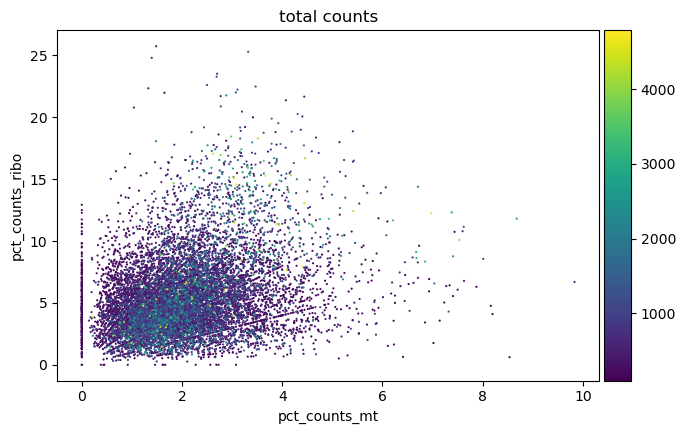

In [11]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p4 = sc.pl.scatter(adata, "pct_counts_mt", "pct_counts_ribo", color="total_counts")

In [12]:
# PFlogPF normalisation
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)

In [13]:
adata

AnnData object with n_obs × n_vars = 12350 × 16721
    obs: 'celltype', 'metacells', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'Pfam_domain_architecture', 'Homo_BBH', 'Drosophila_BBH', 'best_guess', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [14]:
anti_cor_table = get_anti_cor_genes(adata.X.T,
                                    adata.var.index.tolist(),
                                    species="",
                                    pre_remove_pathways=[])

selected_table = anti_cor_table[anti_cor_table["selected"]==True]
print(selected_table)

found 787.168026624 free Gb in /var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T
get_all_remove_genes
12350 617
min_express_n 50
get_n_expressed
pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 8175
8175  genes to remove out of  16721
rewriting the filtered dataset
/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/exprs.hdf5
total_vars: 8546
making the hdf5 spearman output file
/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/spearman.hdf5
get_the_spears
total_vars 8546
	getting spearman correlation


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


empirically determined Cneg cutoff: -0.02272008911047158  for FPR of: 0.001
empirically determined Cpos cutoff: 0.04520647886356466  for FPR of: 0.001
get_real_spear
[0, 5000, 8546]
working on 0 5000 vs 5000 8546
	getting spearman correlation


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/anticor_features/anticor_features.py:402: RuntimeWarning: divide by zero encountered in double_scalars
  FDR_vect[i] = FP_hat_vect[i]/all_sig_neg_vect[i]


                  gene  pre_remove_feature  pre_remove_pathway  \
bin_1            bin_1               False               False   
bin_10271    bin_10271               False               False   
bin_10623    bin_10623               False               False   
bin_10895    bin_10895               False               False   
bin_11190    bin_11190               False               False   
...                ...                 ...                 ...   
model_9947  model_9947               False               False   
model_9949  model_9949               False               False   
model_995    model_995               False               False   
model_9965  model_9965               False               False   
model_9968  model_9968               False               False   

            pre_remove_low_express  n_expressed  percent_expressed  \
bin_1                        False        555.0           0.044939   
bin_10271                    False        460.0           0.037247 

In [15]:
adata.var = pd.concat([adata.var, anti_cor_table], axis=1)

# do some patching to the anti-correlated genes table
adata.var["highly_variable"] = adata.var["selected"].fillna(False)
adata.raw = adata

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_7363/2695319484.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var["highly_variable"] = adata.var["selected"].fillna(False)


In [16]:
adata.uns["proposed_dimensionality"] = 25 # relic from doing topometry
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_pca", metric="cosine", n_pcs=adata.uns["proposed_dimensionality"])
sc.tl.umap(adata, min_dist=0.1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


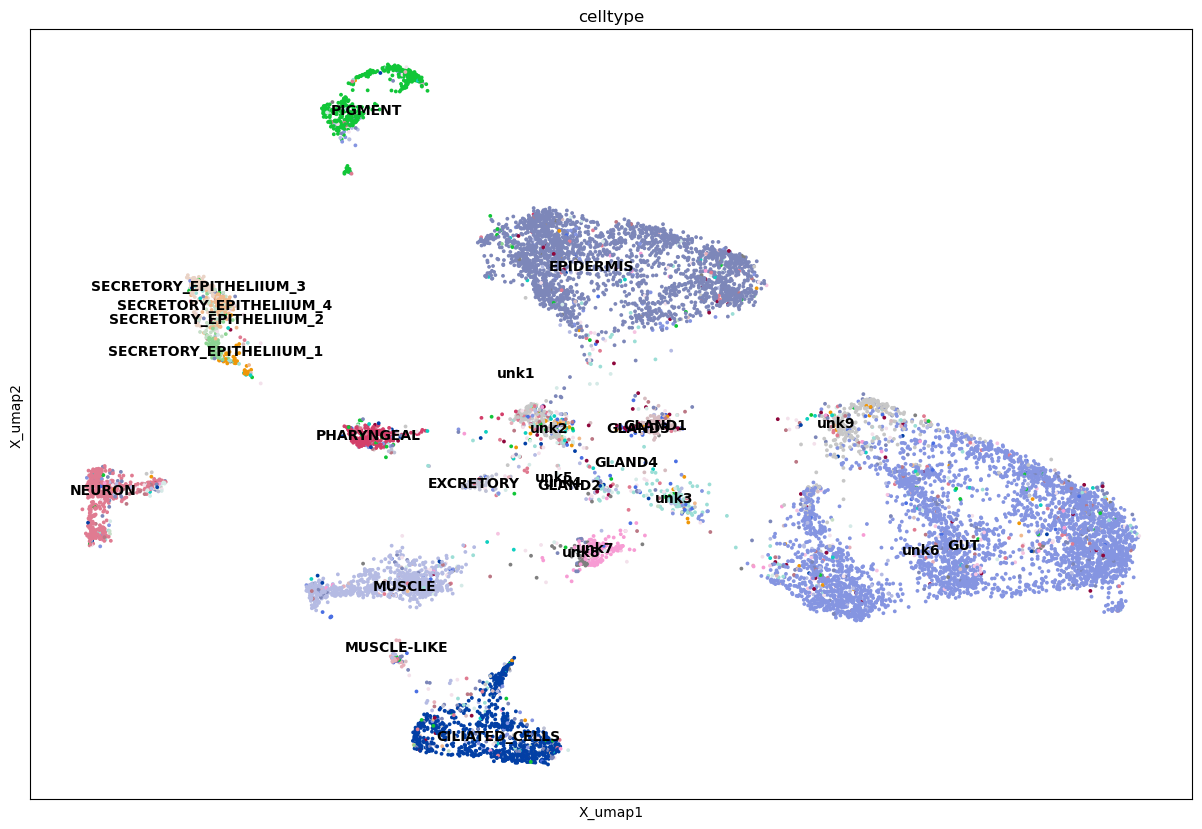

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
sc.pl.embedding(adata, basis="X_umap", color="celltype", legend_loc="on data", ax=ax, s=30)